# Classifying Titles with a Basic Dense Network

In this notebook, I use Reddit post titles, labeled with political lean (i.e. 'Conservative' or 'Liberal') to train a simple dense network. 

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.

In [1]:
# imports & load data

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
reddit_politics = pd.read_csv(
    "../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv")

/kaggle/input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv


In [2]:
# drop irrelevant columns & shuffle the data

reddit_politics = reddit_politics.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments', 'Text', 'Date Created'])
reddit_politics = reddit_politics.sample(frac=1)

In [3]:
# create labels & data

x = reddit_politics["Title"]
y = reddit_politics["Political Lean"]

In [4]:
# split the data

ten_percent = 1285

x_train = x[2571:]
x_val = x[1285:2571]
x_test = x[:1285]

y_train = y[2571:]
y_val = y[1285:2571]
y_test = y[:1285]

In [5]:
# prepare label data by converting 'Conservative' and 'Liberal' strings into 1s and 0s

def prepareLabelData(data):
    # convert to 0s & 1s
    return pd.get_dummies(data)['Conservative'].to_numpy()
    
    
y_train = prepareLabelData(y_train)
y_val = prepareLabelData(y_val)
y_test = prepareLabelData(y_test)

In [6]:
# prepare Title data using Keras vectorization layer and one hot encoding

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vocab_size = 1000 # maximum length of vocabulary
max_len = 100 # maximum length of title

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=max_len)

vectorize_layer.adapt(x_train)

def prepareTitleData(data, vectorize_layer, vocab_size):
    data = data.to_numpy()
    data = vectorize_layer(data)
    data = tf.one_hot(data, vocab_size)
    data = tf.reshape(data, (-1, data.shape[1]*data.shape[2]))
    return data

x_train = prepareTitleData(x_train, vectorize_layer, vocab_size)
x_val = prepareTitleData(x_val, vectorize_layer, vocab_size)
x_test = prepareTitleData(x_test, vectorize_layer, vocab_size)

2022-05-27 17:59:20.925737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:59:21.040696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:59:21.041493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 17:59:21.042690: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
# define and compile the model

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# train the model

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2022-05-27 17:59:24.081914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4113200000 exceeds 10% of free system memory.


Epoch 1/10
21/21 [==============================] - 5s 181ms/step - loss: 0.6547 - accuracy: 0.6476 - val_loss: 0.6711 - val_accuracy: 0.6236
Epoch 2/10
21/21 [==============================] - 3s 169ms/step - loss: 0.6167 - accuracy: 0.6497 - val_loss: 0.6440 - val_accuracy: 0.6236
Epoch 3/10
21/21 [==============================] - 3s 147ms/step - loss: 0.5904 - accuracy: 0.6801 - val_loss: 0.6426 - val_accuracy: 0.6283
Epoch 4/10
21/21 [==============================] - 3s 164ms/step - loss: 0.5604 - accuracy: 0.7141 - val_loss: 0.7532 - val_accuracy: 0.4230
Epoch 5/10
21/21 [==============================] - 3s 146ms/step - loss: 0.5319 - accuracy: 0.7305 - val_loss: 0.6267 - val_accuracy: 0.6501
Epoch 6/10
21/21 [==============================] - 3s 149ms/step - loss: 0.4970 - accuracy: 0.7632 - val_loss: 0.6129 - val_accuracy: 0.6680
Epoch 7/10
21/21 [==============================] - 3s 150ms/step - loss: 0.4729 - accuracy: 0.7857 - val_loss: 0.7458 - val_accuracy: 0.6345
Epoch 

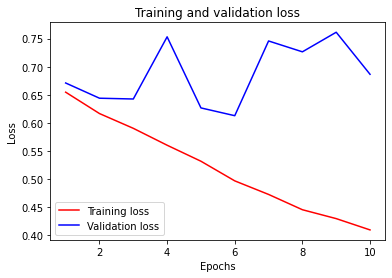

In [9]:
# plot loss over epochs

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss") # "b--" is for "blue dashed line"
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # b is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# get test metrics

from sklearn import metrics

preds = model(x_test)
preds = preds.numpy()
preds = preds>0.5

print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds))
print("Precision is", metrics.precision_score(y_test, preds))
print("Recall is", metrics.recall_score(y_test, preds))

Accuracy is 0.6972762645914397
F1 score is 0.1979381443298969
Precision is 0.8275862068965517
Recall is 0.11241217798594848


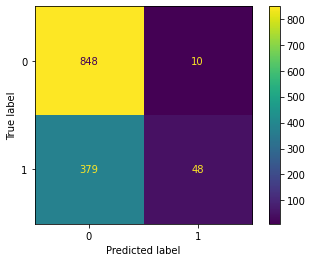

In [11]:
# looking at the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()